In [1]:
using CSV
using Chain
using Dates
using Downloads
using CairoMakie
using DataFrames
using DataFramesMeta
using InvertedIndices
using CategoricalArrays
using AlgebraOfGraphics
resultadosDir = "https://raw.githubusercontent.com/martj42/international_results/master/results.csv";
penaltiesDir = "https://raw.githubusercontent.com/martj42/international_results/master/shootouts.csv";

In [2]:
cd("/Users/ar/Documents/Books/Julia/")

In [3]:
valoresK = CSV.read("Data/valoresK.csv", DataFrame)
penalties = @chain penaltiesDir begin
    Downloads.download
    CSV.File(missingstring = "NA")
    DataFrame
    rename!(["fecha", "local", "visitante", "penaltis"])
    @transform!(:local = categorical(:local), :visitante = categorical(:visitante))
    @transform!(:penaltis = categorical(:penaltis))
end;


In [4]:
elo = @chain resultadosDir begin
    Downloads.download
    CSV.File(missingstring = "NA")
    DataFrame
    rename!(["fecha", "local", "visitante", "goles_local", "goles_visitante", "torneo", "ciudad", "pais", "neutral"])
    @transform!(:torneo = categorical(:torneo))
    @transform!(:local = categorical(:local), :visitante = categorical(:visitante))
    @transform!(:pais = categorical(:pais), :ciudad = categorical(:ciudad))
    leftjoin!(penalties, on = [:fecha, :local, :visitante])
    leftjoin!(valoresK, on = :torneo)
    @subset!(:k .!= 0)
end;

In [11]:
size(elo)

(42269, 11)

In [16]:
ranking062018 = CSV.read("Data/Ranking062018.csv", DataFrame)
@transform!(ranking062018, :Pais = categorical(String63.(:Pais)))
cambiarNombre = antijoin(ranking062018, elo, on =  :Pais => :local)
nombres = ["United States","Iran","DR Congo", "South Korea",
          "Cape Verde", "Ivory Coast","North Macedonia","Curaçao",
          "Kyrgyzstan", "North Korea","Taiwan", "Eswatini", 
          "Saint Kitts and Nevis", "Saint Lucia", 
          "Saint Vincent and the Grenadines",
          "São Tomé and Príncipe","Brunei",
          "United States Virgin Islands"]
for (i,j) in enumerate(cambiarNombre.Pais)
    ranking062018[findfirst(isequal(j), ranking062018.Pais),:Pais] = nombres[i]
end

In [17]:
cambiarNombre

,Posicion,Pais,Puntaje,PuntajeAnt,Diferencia
,Int64,Cat…,Int64,Int64,Float64
1,25,USA,873,880,-7.0
2,37,IR Iran,708,727,-19.0
3,38,Congo DR,706,711,-5.0
4,57,Korea Republic,544,520,24.0
5,65,Cape Verde Islands,478,545,-67.0
6,68,Côte d'Ivoire,463,458,5.0
7,71,FYR Macedonia,451,422,29.0
8,81,Curacao,408,439,-31.0
9,92,Kyrgyz Republic,363,424,-61.0


In [18]:
elo = @chain elo begin
    rightjoin(ranking062018[:,[:Pais]], on = :local => :Pais)
    rightjoin(ranking062018[:,[:Pais]], on = :visitante => :Pais)
end;


In [19]:
size(elo)

(39188, 11)

In [20]:
show(first(elo),allcols=true)

DataFrameRow
 Row │ fecha       local     visitante  goles_local  goles_visitante  torneo    ciudad   pais      neutral  penaltis  k      
     │ Date?       Cat…?     Cat…       Int64?       Int64?           Cat…?     Cat…?    Cat…?     Bool?    Cat…?     Int64? 
─────┼───────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
   1 │ 1872-11-30  Scotland  England              0                0  Friendly  Glasgow  Scotland    false  missing       20

In [21]:
function puntajeElo(Elocal, Evisitante, Rₗ, Rᵥ, gₗ::Int, gᵥ::Int, k::Int, neutral, penaltis)
    gd = abs(gₗ - gᵥ)
    gᵟ = 1 + 0.5*(gd == 2) + (0.75 + .125*(gd - 3))*(gd > 2)
    gₗ > gᵥ ? W= [1.0,0.0] : ( gₗ < gᵥ ? W = [0.0,1.0] : W = [0.5,0.5]) 
    if !ismissing(penaltis)
        if gₗ == gᵥ
            if Elocal == penaltis
                W[1] = 0.75
            else  
                W[2] = 0.75
            end
        end
    end
    e = (Rₗ-Rᵥ+100*(!neutral))/400
    Rₗ += k*gᵟ*(W[1] - 1/(1+10^(-e)))
    Rᵥ += k*gᵟ*(W[2] - 1/(1+10^e))
    return((L = Rₗ, V = Rᵥ))
end


puntajeElo (generic function with 1 method)

In [22]:
puntajeElo(elo.local[1],elo.visitante[1],1500,1500,0,0,20,false,missing)

(L = 1497.1987000039423, V = 1502.8012999960577)

In [23]:
puntajeElo(elo.local[2],elo.visitante[2],1502.8012999960577,1497.1987000039423,4,2,20,false,missing)

(L = 1513.3774691357255, V = 1486.6225308642745)

In [24]:
puntajeElo("Germany","Saudi Arabia",1600,1336,2,1,20,false, missing)

(L = 1602.1909872255414, V = 1333.8090127744586)

In [62]:
puntajes = DataFrame(Pais = ranking062018.Pais, puntaje = 850.0)
puntajes = Dict(Pair.(puntajes.Pais, puntajes.puntaje));

In [57]:
puntajes

Dict{CategoricalValue{String63, UInt32}, Float64} with 205 entries:
  "Finland"            => 850.0
  "Sweden"             => 850.0
  "Cambodia"           => 850.0
  "Lesotho"            => 850.0
  "Peru"               => 850.0
  "Japan"              => 850.0
  "Indonesia"          => 850.0
  "Gabon"              => 850.0
  "Togo"               => 850.0
  "Canada"             => 850.0
  "North Macedonia"    => 850.0
  "Sri Lanka"          => 850.0
  "Bangladesh"         => 850.0
  "Senegal"            => 850.0
  "Kosovo"             => 850.0
  "Tajikistan"         => 850.0
  "Curaçao"            => 850.0
  "Ethiopia"           => 850.0
  "Dominican Republic" => 850.0
  "Vietnam"            => 850.0
  "South Sudan"        => 850.0
  "Taiwan"             => 850.0
  "Timor-Leste"        => 850.0
  "Morocco"            => 850.0
  "Libya"              => 850.0
  ⋮                    => ⋮

In [55]:
collect(keys(puntajes))

205-element CategoricalArray{String63,1,UInt32}:
 "Finland"
 "Sweden"
 "Cambodia"
 "Lesotho"
 "Peru"
 "Japan"
 "Indonesia"
 "Gabon"
 "Togo"
 "Canada"
 "North Macedonia"
 "Sri Lanka"
 "Bangladesh"
 ⋮
 "Cape Verde"
 "Gambia"
 "Pakistan"
 "Portugal"
 "Tahiti"
 "DR Congo"
 "Qatar"
 "Oman"
 "Nicaragua"
 "Singapore"
 "Cayman Islands"
 "Iraq"

In [35]:
n1 = findfirst(isequal(Date(2018,06,07)), elo.fecha )-1

36020

In [63]:
for i in 1:n1
    nuevos = puntajeElo(elo.local[i],elo.visitante[i],
                        puntajes[elo.local[i]], puntajes[elo.visitante[i]],
                        elo.goles_local[i], elo.goles_visitante[i],
                        elo.k[i], elo.neutral[i],elo.penaltis[i])
    puntajes[elo.local[i]] = nuevos.L
    puntajes[elo.visitante[i]] = nuevos.V
end

In [64]:
elo062018 = DataFrame( Pais = collect(keys(puntajes)), Puntaje = collect(values(puntajes)))
comp062018 = innerjoin(ranking062018,elo062018, on = :Pais, makeunique=true)

,Posicion,Pais,Puntaje,PuntajeAnt,Diferencia,Puntaje_1
,Int64,Cat…,Int64,Int64,Float64,Float64
1,63,Finland,486,507,-21.0,985.441
2,24,Sweden,880,889,-9.0,1181.99
3,166,Cambodia,103,105,-2.0,401.981
4,147,Lesotho,175,172,3.0,738.656
5,11,Peru,1125,1106,19.0,1362.8
6,61,Japan,521,528,-7.0,1126.54
7,164,Indonesia,111,111,0.0,726.41
8,85,Gabon,390,374,16.0,850.722
9,125,Togo,241,242,-1.0,824.803


In [ ]:
set_aog_theme!()
update_theme!(fontsize=20,markersize=13)
draw(data(j)*mapping(:Puntaje => "Puntaje FIFA",:Puntaje_1 => "Puntaje Élő")*visual(Scatter, color = :darkred))
using AlgebraOfGraphics, CairoMakie
set_aog_theme!()
j = data(comp062018)*
    mapping(:Puntaje => "Puntaje FIFA",:Puntaje_1 => "Puntaje Élő")*
    visual(Scatter, color = :darkred)
    text!("center", position = (1000, 1000), align = (:center, :center))
draw(j)


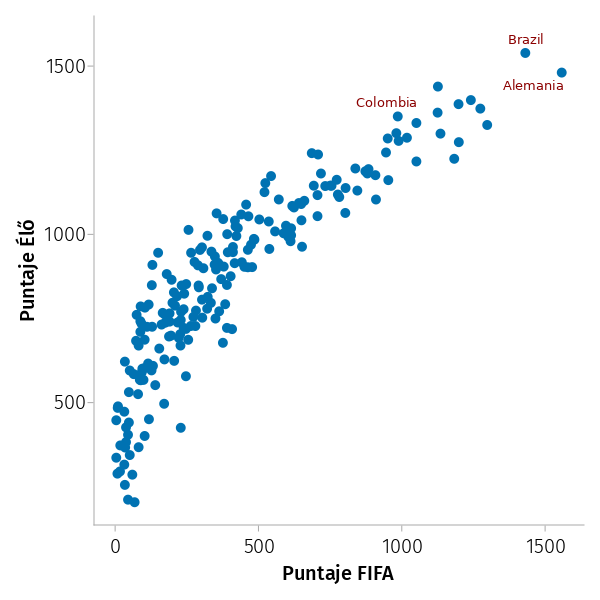

In [95]:
CairoMakie.activate!()
fig, ax, p = scatter(comp062018.Puntaje, comp062018.Puntaje_1;
                                axis = (; xlabel = "Puntaje FIFA", 
                                ylabel = "Puntaje Élő"),
                                figure = (; resolution=(600, 600)))
text!("Brazil", position = (1431, 1540.08+40), align = (:center, :center), 
      color=:darkred, textsize = 13)
text!("Alemania", position = (1558, 1481.08-40), align = (:right, :center), 
      color=:darkred, textsize = 13)
text!("Colombia", position = (986-40, 1351.46+40), align = (:center, :center), 
      color=:darkred, textsize = 13)
fig

In [88]:
@subset(comp062018, :Pais .== "Colombia")

,Posicion,Pais,Puntaje,PuntajeAnt,Diferencia,Puntaje_1
,Int64,Cat…,Int64,Int64,Float64,Float64
1,16,Colombia,986,989,-3.0,1351.46


In [91]:
sort(comp062018.Puntaje_1)

205-element Vector{Float64}:
  205.12650710813705
  212.74082670055893
  256.6653634739992
  287.0339982098342
  290.11104037999564
  296.6293843740826
  316.8376059042874
  337.43766635510707
  345.3081019066336
  367.61060176698726
  368.6416979572198
  373.95201111003735
  383.7131250166419
    ⋮
 1300.3819209740805
 1301.6721513844257
 1326.091874724044
 1331.991589455932
 1351.4609077774392
 1362.8005944228787
 1374.724528574274
 1387.9976485209966
 1400.0447936460005
 1440.2289564306604
 1481.7669278889837
 1540.0813160137707

In [96]:
puntajes = DataFrame(Pais = ranking062018.Pais, puntaje = 1600.0 .- 4 .*(ranking062018.Posicion .-1))
puntajes = Dict(Pair.(puntajes.Pais, puntajes.puntaje));

In [97]:
n2 = findlast(isequal(Date(2022,03,30)), elo.fecha)

39188

In [256]:
last(elo)

,fecha,local,visitante,goles_local,goles_visitante,torneo
,Date?,Cat…?,Cat…,Int64?,Int64?,Cat…?
39188,2022-03-30,Solomon Islands,New Zealand,0,5,FIFA World Cup qualification


In [98]:
for i in (n1+1):n2
    nuevos = puntajeElo(elo.local[i],elo.visitante[i],
                        puntajes[elo.local[i]], puntajes[elo.visitante[i]],
                        elo.goles_local[i], elo.goles_visitante[i],
                        elo.k[i], elo.neutral[i],elo.penaltis[i])
    puntajes[elo.local[i]] = nuevos.L
    puntajes[elo.visitante[i]] = nuevos.V
end

In [99]:
elo032022 = DataFrame( Pais = collect(keys(puntajes)), Puntaje = collect(values(puntajes)))


,Pais,Puntaje
,Cat…,Float64
1,Finland,1433.87
2,Sweden,1515.25
3,Cambodia,884.025
4,Lesotho,1016.09
5,Peru,1543.5
6,Japan,1549.59
7,Indonesia,975.798
8,Gabon,1272.76
9,Togo,1174.35


In [100]:
ranking032022 = CSV.read("Data/Ranking032022.csv", DataFrame)
@transform!(ranking032022, :Pais = categorical(String63.(:Pais)))


,Posicion,Pais,Puntaje,PuntajeAnt,Diferencia
,Int64,Cat…,Float64,Float64,Float64
1,1,Brazil,1832.69,1823.42,9.27
2,2,Belgium,1827.0,1828.45,-1.45
3,3,France,1789.85,1786.15,3.7
4,4,Argentina,1765.13,1766.99,-1.86
5,5,England,1761.71,1755.52,6.19
6,6,Italy,1723.31,1740.77,-17.46
7,7,Spain,1709.19,1704.75,4.44
8,8,Portugal,1674.78,1660.25,14.53
9,9,Mexico,1658.82,1647.9,10.92


In [101]:
cambiarNombre = antijoin(ranking032022, ranking062018, on =  :Pais)
nombres = ["United States","Iran","South Korea", "Ivory Coast",
"DR Congo", "Cape Verde","Kyrgyzstan","North Korea",
"Saint Kitts and Nevis", "Taiwan","Saint Vincent and the Grenadines",
"Saint Lucia", "Brunei", "Tonga", "Bahamas", "Somalia", "Eritrea",
"Turks and Caicos Islands", "United States Virgin Islands", "Anguilla"]
for (i,j) in enumerate(cambiarNombre.Pais)
    ranking032022[findfirst(isequal(j), ranking032022.Pais),:Pais] = nombres[i]
end

,Posicion,Pais,Puntaje,PuntajeAnt,Diferencia
,Int64,Cat…,Float64,Float64,Float64
1,199,Tonga,861.81,861.81,0.0
2,201,Bahamas,858.5,858.5,0.0
3,202,Somalia,857.39,873.71,-16.32
4,204,Eritrea,855.56,855.56,0.0
5,206,Turks and Caicos Islands,839.84,839.84,0.0
6,210,Anguilla,792.34,792.34,0.0


In [103]:

comp032022= leftjoin(elo032022,ranking032022, on = :Pais, makeunique=true)

,Pais,Puntaje,Posicion,Puntaje_1,PuntajeAnt,Diferencia
,Cat…,Float64,Int64?,Float64?,Float64?,Float64?
1,Brazil,1816.67,1,1832.69,1823.42,9.27
2,Belgium,1780.08,2,1827.0,1828.45,-1.45
3,France,1809.41,3,1789.85,1786.15,3.7
4,Argentina,1779.73,4,1765.13,1766.99,-1.86
5,England,1754.51,5,1761.71,1755.52,6.19
6,Italy,1724.3,6,1723.31,1740.77,-17.46
7,Spain,1735.8,7,1709.19,1704.75,4.44
8,Portugal,1687.78,8,1674.78,1660.25,14.53
9,Mexico,1577.55,9,1658.82,1647.9,10.92


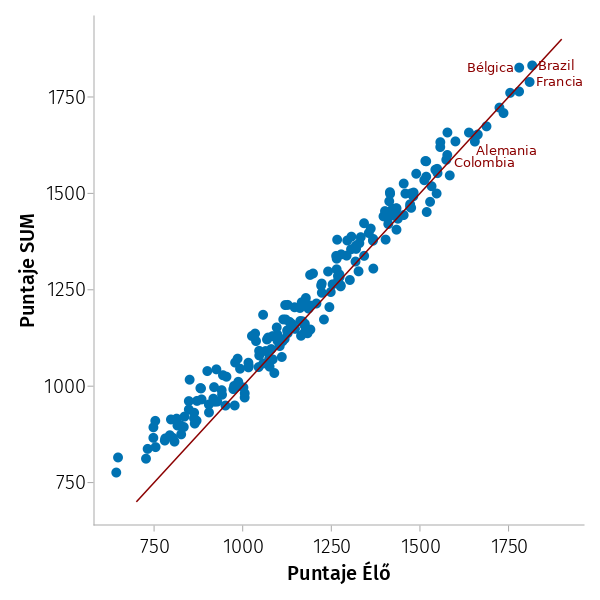

In [147]:
CairoMakie.activate!()
x = 700:20:1900
fig, ax, p = scatter(comp032022.Puntaje, comp032022.Puntaje_1;
                                axis = (; xlabel = "Puntaje Élő", 
                                ylabel = "Puntaje SUM"),
                                figure = (; resolution=(600, 600)))
                                
text!("Brazil", position = (1816.67+20, 1832.69), align = (:left, :center), 
      color=:darkred, textsize = 13)
text!("Alemania", position = (1658.5, 1650.53-40), align = (:left, :center), 
      color=:darkred, textsize = 13)
text!("Colombia", position = (1577.13+20, 1600.52-20), align = (:left, :center), 
      color=:darkred, textsize = 13)
text!("Francia", position = (1810+20, 1790), align = (:left, :center), 
      color=:darkred, textsize = 13)
text!("Bélgica", position = (1780.08-20, 1827.0), align = (:right, :center), 
      color=:darkred, textsize = 13)

lines!(x, x, color =:darkred)
fig

In [ ]:
using FreqTables
freqtable(unique(vcat(elo.local, elo.visitante)))